# EDB: Layout Components

This example shows how you can use EDB to create a parametric component using
3D Layout and use it in HFSS 3D.

## Perform required imports

Perform required imports.

In [1]:
import os
import tempfile

import ansys.aedt.core
import pyedb

## Set non-graphical mode

In [2]:
non_graphical = False

## Create data classes

Data classes are useful to do calculations and store variables.
There are three data classes: ``Patch``, ``Line``, and ``Array``.

In [3]:
class Patch:
    def __init__(self, width=0.0, height=0.0, position=0.0):
        self.width = width
        self.height = height
        self.position = position

    @property
    def points(self):
        return [
            [self.position, "-{}/2".format(self.height)],
            ["{} + {}".format(self.position, self.width), "-{}/2".format(self.height)],
            ["{} + {}".format(self.position, self.width), "{}/2".format(self.height)],
            [self.position, "{}/2".format(self.height)],
        ]


class Line:
    def __init__(self, length=0.0, width=0.0, position=0.0):
        self.length = length
        self.width = width
        self.position = position

    @property
    def points(self):
        return [
            [self.position, "-{}/2".format(self.width)],
            ["{} + {}".format(self.position, self.length), "-{}/2".format(self.width)],
            ["{} + {}".format(self.position, self.length), "{}/2".format(self.width)],
            [self.position, "{}/2".format(self.width)],
        ]


class LinearArray:
    def __init__(self, nb_patch=1, array_length=10e-3, array_width=5e-3):
        self.nbpatch = nb_patch
        self.length = array_length
        self.width = array_width

    @property
    def points(self):
        return [
            [-1e-3, "-{}/2-1e-3".format(self.width)],
            ["{}+1e-3".format(self.length), "-{}/2-1e-3".format(self.width)],
            ["{}+1e-3".format(self.length), "{}/2+1e-3".format(self.width)],
            [-1e-3, "{}/2+1e-3".format(self.width)],
        ]

## Launch EDB

PyEDB.Edb allows to open existing Edb project or create a new empty project.

In [4]:
temp_dir = tempfile.TemporaryDirectory(suffix=".ansys")
aedb_path = os.path.join(temp_dir.name, "linear_array.aedb")

# Select EDB version (change it manually if needed, e.g. "2025.1")
edb_version = "2025.2"
print(f"EDB version: {edb_version}")

# Create an instance of the Edb class.
edb = pyedb.Edb(edbpath=aedb_path, version=edb_version)

EDB version: 2025.2


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 11:21:16.339758


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: create_edb completed in 8.6088 seconds.


PyEDB INFO: EDB C:\Users\ansys\AppData\Local\Temp\tmpwtv85wbk.ansys\linear_array.aedb created correctly.


PyEDB INFO: EDB initialization completed in 8.6881 seconds.


In [5]:
# Add stackup layers
layers = {
    "materials": {"copper_high_cond": {"conductivity": 60000000}},
    "layers": {
        "TOP": {"type": "signal", "thicness": "35um", "material": "copper_high_cond"},
        "Substrat": {"type": "dielectric", "thicness": "0.5mm", "material": "Duroid (tm)"},
        "GND": {"type": "signal", "thicness": "35um", "material": "copper"},
        "Gap": {"type": "dielectric", "thicness": "0.05mm", "material": "Air"},
        "Virt_GND": {"type": "signal", "thicness": "35um", "material": "copper"},
    },
}

In [6]:
edb.stackup.load(layers)

True

Create the first patch and feed line using the ``Patch``, ``Line``classes defined above.

Define parameters:

In [7]:
edb["w1"] = 1.4e-3
edb["h1"] = 1.2e-3
edb["initial_position"] = 0.0
edb["l1"] = 2.4e-3
edb["trace_w"] = 0.3e-3

first_patch = Patch(width="w1", height="h1", position="initial_position")
edb.modeler.create_polygon(first_patch.points, "TOP", net_name="Array_antenna")

First line

In [8]:
first_line = Line(length="l1", width="trace_w", position=first_patch.width)
edb.modeler.create_polygon(first_line.points, "TOP", net_name="Array_antenna")

Now use the ``LinearArray`` class to create the array.

In [9]:
edb["w2"] = 2.29e-3
edb["h2"] = 3.3e-3
edb["l2"] = 1.9e-3
edb["trace_w2"] = 0.2e-3

patch = Patch(width="w2", height="h2")
line = Line(length="l2", width="trace_w2")
linear_array = LinearArray(nb_patch=8, array_width=patch.height)

current_patch = 1
current_position = "{} + {}".format(first_line.position, first_line.length)

while current_patch <= linear_array.nbpatch:
    patch.position = current_position
    edb.modeler.create_polygon(patch.points, "TOP", net_name="Array_antenna")
    current_position = "{} + {}".format(current_position, patch.width)
    if current_patch < linear_array.nbpatch:
        line.position = current_position
        edb.modeler.create_polygon(line.points, "TOP", net_name="Array_antenna")
        current_position = "{} + {}".format(current_position, line.length)
    current_patch += 1

linear_array.length = current_position

Add the ground conductor.

In [10]:
edb.modeler.create_polygon(linear_array.points, "GND", net_name="GND")

Add the connector pin to use to assign the port.

In [11]:
edb.padstacks.create(padstackname="Connector_pin", holediam="100um", paddiam="0", antipaddiam="200um")
con_pin = edb.padstacks.place(
    ["{}/4.0".format(first_patch.width), 0],
    "Connector_pin",
    net_name="Array_antenna",
    fromlayer="TOP",
    tolayer="GND",
    via_name="coax",
)

PyEDB INFO: Padstack Connector_pin create correctly


Add a connector ground.

In [12]:
edb.modeler.create_polygon(first_patch.points, "Virt_GND", net_name="GND")
edb.padstacks.create("gnd_via", "100um", "0", "0")
edb["via_spacing"] = 0.2e-3
con_ref1 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[0][0], "via_spacing"),
        "{} + {}".format(first_patch.points[0][1], "via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref2 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[1][0], "-via_spacing"),
        "{} + {}".format(first_patch.points[1][1], "via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref3 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[2][0], "-via_spacing"),
        "{} + {}".format(first_patch.points[2][1], "-via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref4 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[3][0], "via_spacing"),
        "{} + {}".format(first_patch.points[3][1], "-via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)

PyEDB INFO: Padstack gnd_via create correctly


Define the port.

In [13]:
edb.padstacks.set_solderball(con_pin, "Virt_GND", isTopPlaced=False, ballDiam=0.1e-3)
port_name = edb.padstacks.create_coax_port(con_pin)

Display the model using the ``Edb.nets.plot()`` method.

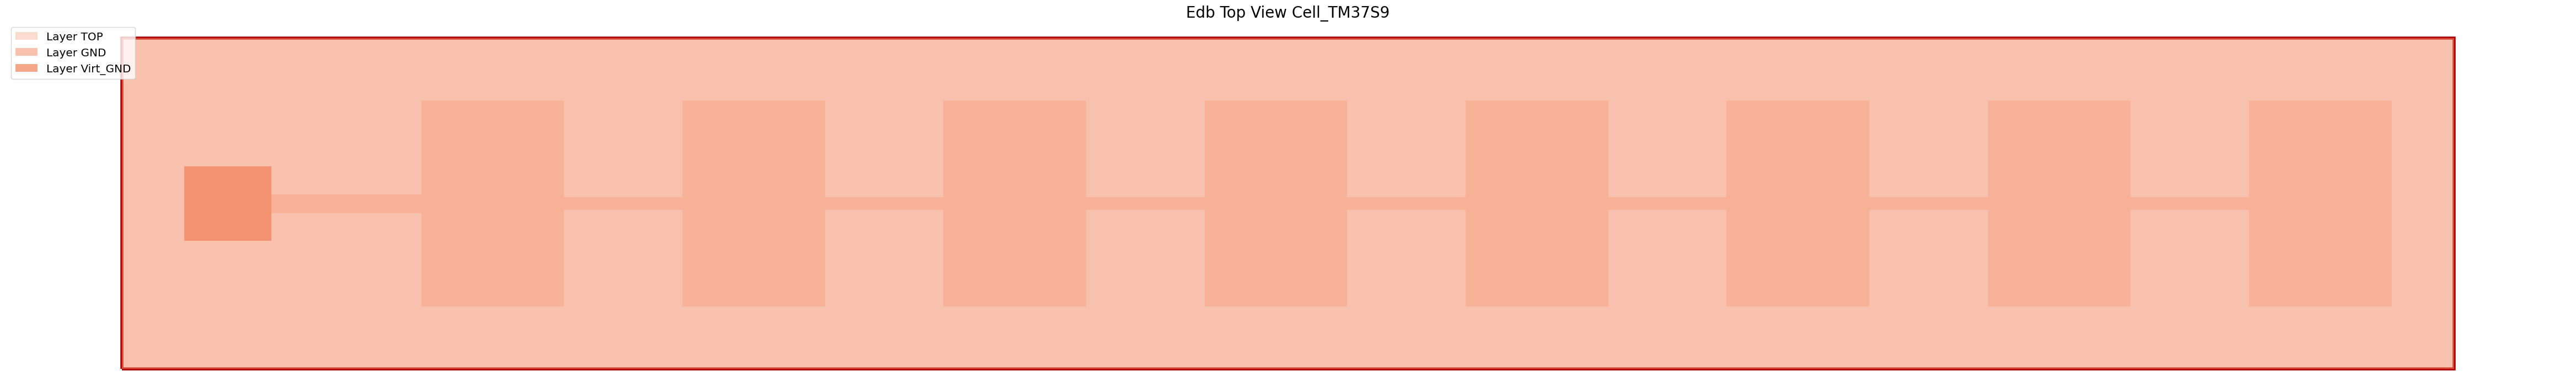

PyEDB INFO: Plot Generation time 0.268


(<Figure size 6000x3000 with 1 Axes>,
 <Axes: title={'center': 'Edb Top View Cell_TM37S9'}>)

In [14]:
edb.nets.plot()

The EDB is complete. Now close the EDB and import it into HFSS as a "Layout Component".

In [15]:
edb.save_edb()
edb.close_edb()
print("EDB saved correctly to {}. You can import in AEDT.".format(aedb_path))

PyEDB INFO: Save Edb file completed in 0.0000 seconds.


PyEDB INFO: Close Edb file completed in 0.0158 seconds.


EDB saved correctly to C:\Users\ansys\AppData\Local\Temp\tmpwtv85wbk.ansys\linear_array.aedb. You can import in AEDT.


## 3D component in HFSS

First create an instance of the ``pyaedt.Hfss`` class. If you set
> ``non_graphical = False

then AEDT user interface will be visible after the following cell is executed.
It is now possible to monitor the progress in the UI as each of the following cells is executed.
All commands can be run without the UI by changing the value of ``non_graphical``.

In [16]:
h3d = ansys.aedt.core.Hfss(
    project="Demo_3DComp",
    design="Linear_Array",
    version="2025.2",
    new_desktop=True,
    non_graphical=non_graphical,
    close_on_exit=True,
    solution_type="Terminal",
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_27438c00-f4a1-4184-9127-3a4410ecd734.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 4948.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project Demo_3DComp has been created.


PyAEDT INFO: Added design 'Linear_Array' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


Set units to ``mm``.

In [17]:
h3d.modeler.model_units = "mm"

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


## Import the EDB as a 3D component

One or more layout components can be imported into HFSS.
The combination of layout data and 3D CAD data helps streamline model creation and setup.

In [18]:
component = h3d.modeler.insert_layout_component(aedb_path, parameter_mapping=True)

PyEDB INFO: Star initializing Edb 11:21:59.914472


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database linear_array.aedb Opened in 2025.2


PyEDB INFO: Cell Cell_TM37S9 Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 0.0162 seconds.


PyEDB INFO: EDB initialization completed in 0.0162 seconds.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Close Edb file completed in 0.0000 seconds.


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\pytest-of-ansys\pytest-1002\Demo_3DComp.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\pytest-of-ansys\pytest-1002\Demo_3DComp.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.01573324203491211


PyEDB INFO: Star initializing Edb 11:22:01.622378


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB WARNING: AEDT project-related file C:\Users\ansys\AppData\Local\Temp\pytest-of-ansys\pytest-1002\Demo_3DComp.aedb\LayoutComponents\linear_array0\linear_array0.aedt.lock exists and may need to be deleted before opening the EDB in HFSS 3D Layout.


PyEDB INFO: Database linear_array0.aedb Opened in 2025.2


PyEDB INFO: Cell Cell_TM37S9 Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 0.0179 seconds.


PyEDB INFO: EDB initialization completed in 0.0179 seconds.


## Expose the component parameters

If a layout component is parametric, you can expose and change parameters in HFSS

In [19]:
component.parameters

w1_name = "{}_{}".format("w1", h3d.modeler.user_defined_component_names[0])
h3d[w1_name] = 0.0015

### Radiation Boundary Assignment

The 3D domain includes the air volume surrounding the antenna.
This antenna will be simulted from 20 GHz - 50 GHz.

A "radiation boundary" will be assigned to the outer boundaries of the domain.
This boundary should be roughly one quarter wavelength away from the radiating structure:

$$ \lambda/4 = \frac{c_0}{4 f} \approx 2.8mm $$

In [20]:
h3d.modeler.fit_all()

h3d.modeler.create_air_region(2.8, 2.8, 2.8, 2.8, 2.8, 2.8, is_percentage=False)
h3d.assign_radiation_boundary_to_objects("Region")

PyAEDT INFO: Boundary Radiation Rad__9SKJBM has been created.


Rad__9SKJBM

### Set up analysis

The finite element mesh is adapted iteratively.
The maximum number of adaptive passes is set using the ``MaximumPasses`` property.
This model converges such that the $S_{11}$ is independent of the mesh.
The default accuracy setting is:
$$ \max(|\Delta S|) < 0.02 $$

In [21]:
setup = h3d.create_setup()
setup.props["Frequency"] = "20GHz"
setup.props["MaximumPasses"] = 10

Specify properties of the frequency sweep:

In [22]:
sweep1 = setup.add_sweep(name="20GHz_to_50GHz")
sweep1.props["RangeStart"] = "20GHz"
sweep1.props["RangeEnd"] = "50GHz"
sweep1.update()

True

Solve the project

In [23]:
h3d.analyze()

PyAEDT INFO: Project Demo_3DComp Saved correctly


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 3.0m 2.0s


True

## Plot results outside AEDT

Plot results using Matplotlib.

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\pytest-of-ansys\pytest-1002\Demo_3DComp.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\pytest-of-ansys\pytest-1002\Demo_3DComp.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0402677059173584


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.015653371810913086
Time to initialize solution data:0.031726837158203125


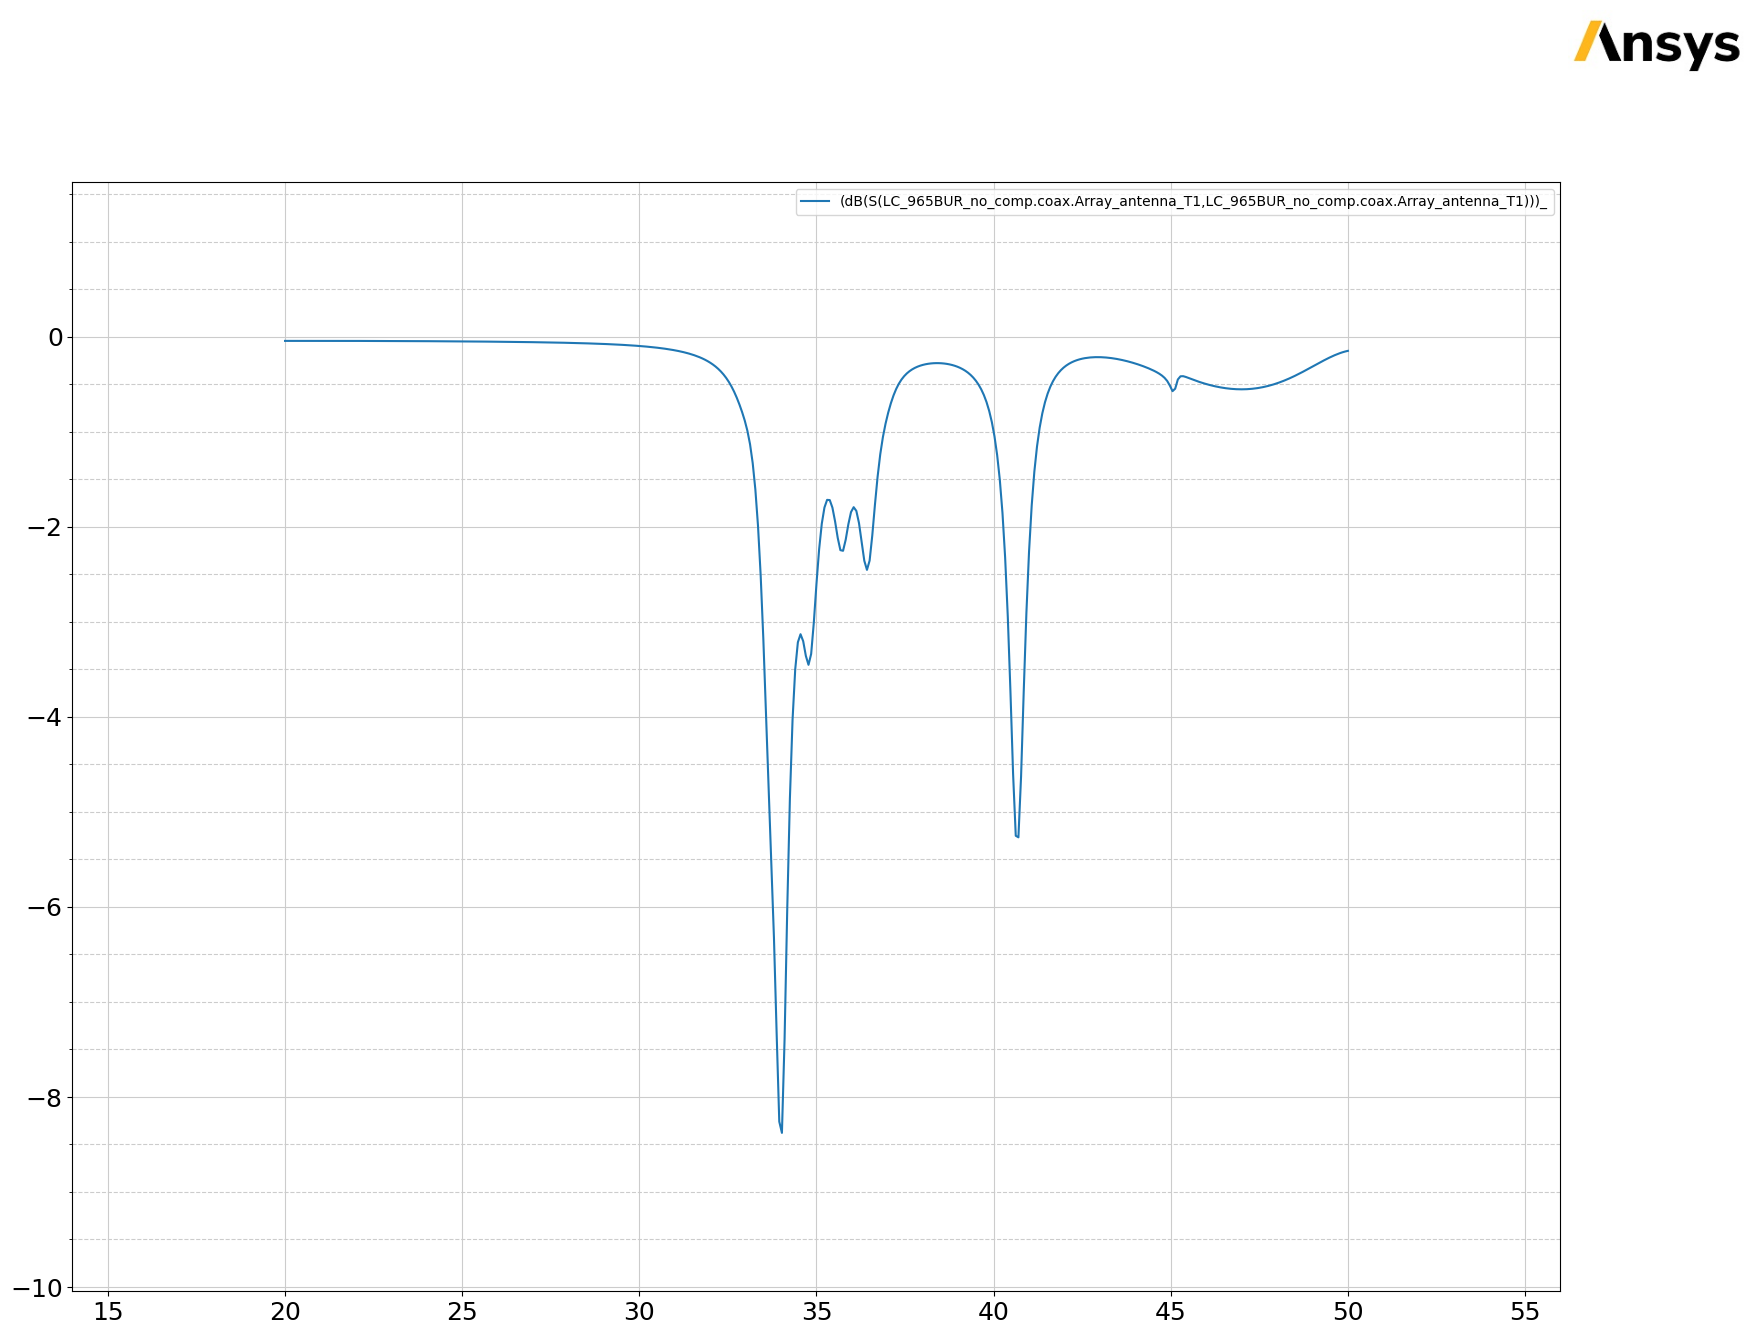

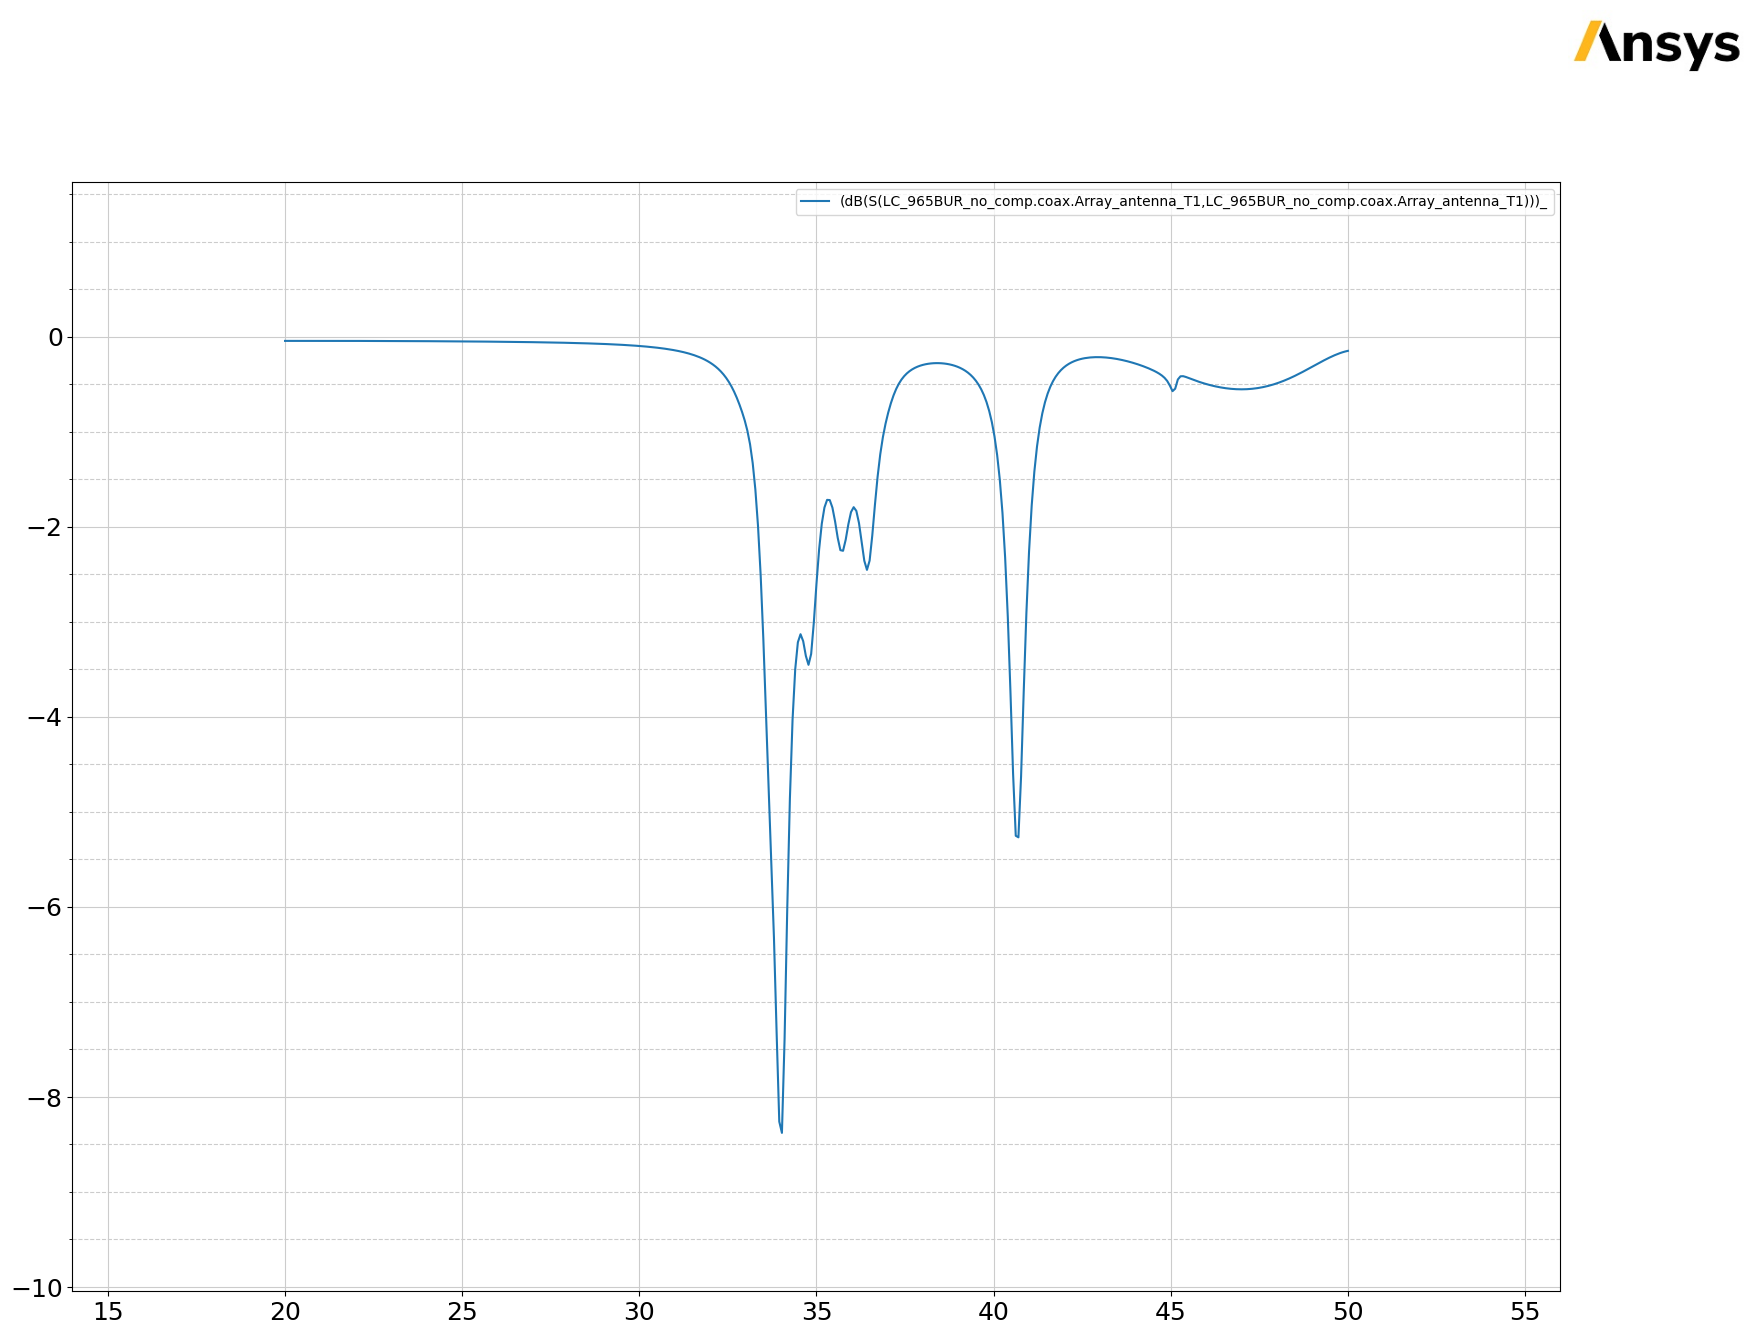

In [24]:
trace = h3d.get_traces_for_plot()
solution = h3d.post.get_solution_data(trace[0])
solution.plot()

## Plot far fields in AEDT

Plot radiation patterns in AEDT.

In [25]:
variations = {}
variations["Freq"] = ["20GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
h3d.insert_infinite_sphere(name="3D")

new_report = h3d.post.reports_by_category.far_field("db(RealizedGainTotal)", h3d.nominal_adaptive, "3D")
new_report.variations = variations
new_report.primary_sweep = "Theta"
new_report.create("Realized2D")

True

## Plot far fields in AEDT

Plot radiation patterns in AEDT

In [26]:
new_report.report_type = "3D Polar Plot"
new_report.secondary_sweep = "Phi"
new_report.create("Realized3D")

True

## Plot far fields outside AEDT

Plot radiation patterns outside AEDT

PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.015674829483032227


Class: ansys.aedt.core.visualization.plot.matplotlib.ReportPlotter

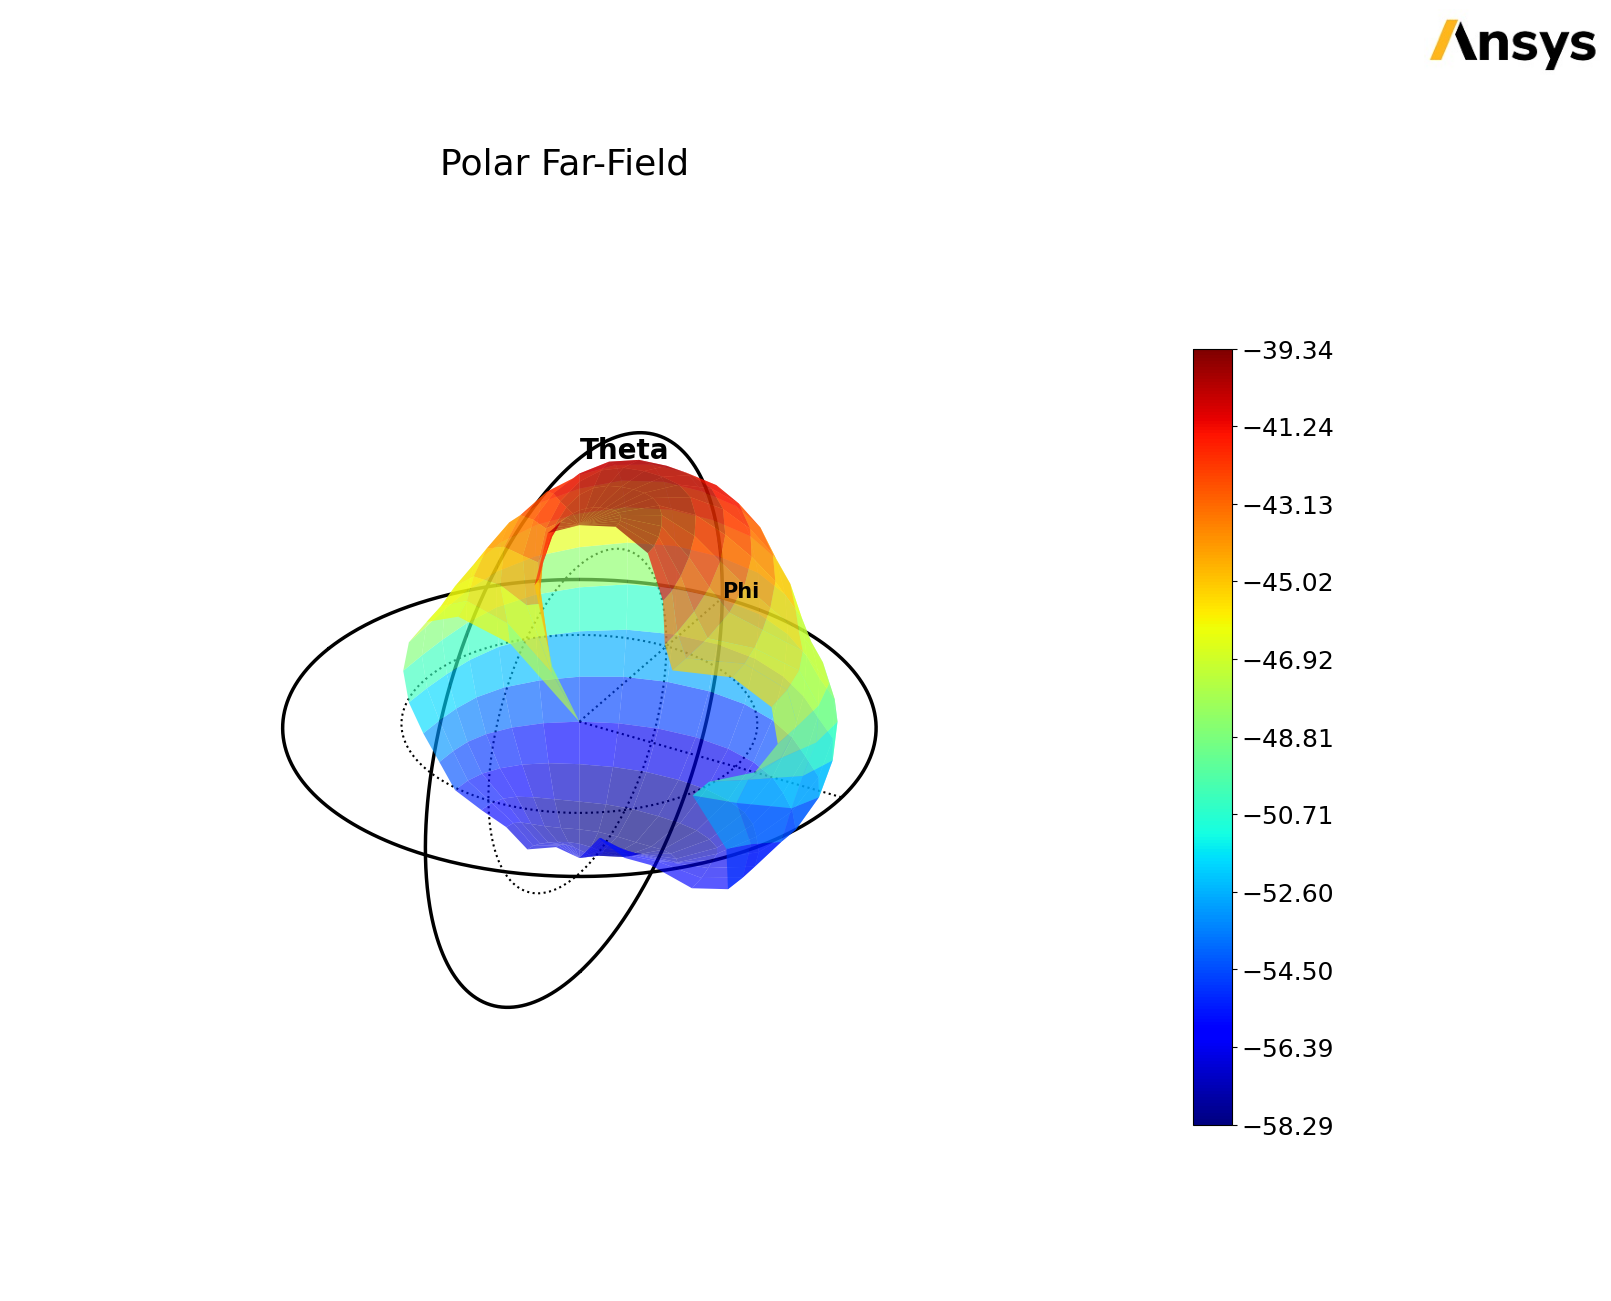

In [27]:
solutions_custom = new_report.get_solution_data()
solutions_custom.plot_3d()

## Plot E Field on nets and layers

Plot E Field on nets and layers in AEDT

In [28]:
h3d.post.create_fieldplot_layers_nets(
    [["TOP", "Array_antenna"]],
    "Mag_E",
    intrinsics={"Freq": "20GHz", "Phase": "0deg"},
    plot_name="E_Layers",
)

PyAEDT INFO: Active Design set to Linear_Array


Class: ansys.aedt.core.visualization.post.field_data.FieldPlot

## Close AEDT

After the simulation completes, the application can be released from the
:func:`ansys.aedt.core.Desktop.release_desktop` method.
All methods provide for saving the project before closing AEDT.

In [29]:
h3d.save_project(os.path.join(temp_dir.name, "test_layout.aedt"))
h3d.release_desktop()

PyAEDT INFO: Project test_layout Saved correctly


PyEDB INFO: Close Edb file completed in 0.0108 seconds.


PyAEDT INFO: Desktop has been released and closed.


True

### Clean up the temporary directory

The following command removes the project and the temporary directory.
If you'd like to save this project, save it to a folder of your choice prior
to running the following cell.

In [30]:
temp_dir.cleanup()